In [19]:
import geopandas
import folium
import cartopy
import rasterio
import rasterio.mask
from rasterio.plot import show
import numpy as np

In [20]:
# Read geojson files
gdf_bound = geopandas.read_file('data/vietnam_bound.geojson')
gdf_road = geopandas.read_file('data/vietnam_roadnet.geojson')
gdf_hosp = geopandas.read_file('data/vietnam_hospital.geojson')
# Read raster file, There is only 1 layer, so will read this layer and close the file
dataset = rasterio.open('data/Flood Risk/geonode__fl1010irmt.tif')
ras = dataset.read(1)


## Boundaries Flood Risk

In [21]:
gdf_bound.head(1)

GID_0   NAME_0    GID_1    NAME_1 VARNAME_1 NL_NAME_1 TYPE_1 ENGTYPE_1  \
0   VNM  Vietnam  VNM.1_1  An Giang  An Giang      None   Tỉnh  Province   

   CC_1 HASC_1                                           geometry  
0  None  VN.AG  POLYGON ((105.37450 10.24604, 105.33623 10.234...

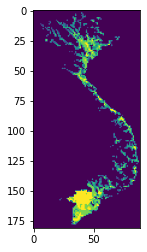

<AxesSubplot:>

In [22]:
# Simple plot without mapping
out_image, out_transform = rasterio.mask.mask(dataset, gdf_bound['geometry'], crop=True)
out_meta = dataset.meta
show(out_image)

In [23]:
# Create a mask for each location and add the mean value as column
res_col = []
for prov_name in gdf_bound['NAME_1'].unique():
    df_filt = gdf_bound[gdf_bound['NAME_1'] == prov_name]
    gtraster, bound = rasterio.mask.mask(dataset, df_filt['geometry'], crop=True)
    gdf_bound.loc[gdf_bound['NAME_1'] == prov_name, 'avg'] = np.mean((gtraster[0]))

<AxesSubplot:>

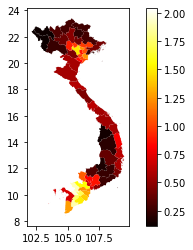

In [24]:
# Simple plot of heat data included
gdf_bound.plot(column='avg', cmap='hot', legend=True)

In [25]:
gdf_bound = gdf_bound.reset_index()
gdf_bound['index'] = gdf_bound['index'].astype(str)

In [26]:
# Map with folium
geo = geopandas.GeoSeries(gdf_bound.set_index('index')['geometry']).to_json()
m = folium.Map(location=[14.0583, 108.2772], zoom_start=6)
folium.Choropleth(
    geo_data = geo,
    name = 'Choropleth',
    data = gdf_bound,
    columns = ['index','avg'],
    key_on = 'feature.id',
    fill_color = 'Reds',
    fill_opacity = 0.8,
    line_opacity = 1,
    legend_name = 'Average Flood Risk',
    smooth_factor=  1
).add_to(m)

m

## Road Flood Risk

<AxesSubplot:>

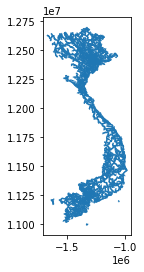

In [27]:
# Simple road plot
gdf_road.plot()

In [28]:
gdf_road = gdf_road.reset_index()

In [49]:
dataset.crs
gdf_road = gdf_road.to_crs("EPSG:4326")


In [51]:

# Create a mask for each location and add the mean value as column
res_col = []
for road in gdf_road['index']:
    df_filt = gdf_road[gdf_road['index'] == road]
    gtraster, bound = rasterio.mask.mask(dataset, df_filt['geometry'], crop=True)
    gdf_road.loc[gdf_road['index'] == road, 'avg'] = np.mean((gtraster[0]))

<AxesSubplot:>

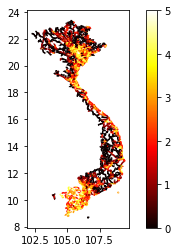

In [111]:
# Simple plot of heat data included
gdf_road.plot(column='avg', cmap='hot', legend=True)

In [109]:
gdf_road['avg'] = round(gdf_road['avg']).astype(int)
gdf_road['index'] = gdf_road['index'].astype(str)

array([0, 3, 5, 4, 2, 1])

In [171]:
# Map with folium
colors = {0: 'Green', 1: 'Green', 2: 'Orange', 3: 'Orange', 4: 'Red', 5: 'Red'}
geo = geopandas.GeoSeries(gdf_road['geometry']).to_json()  
m = folium.Map(location=[14.0583, 108.2772], zoom_start=6)
for flood_r in gdf_road['avg'].unique():
    gdf_f = gdf_road[gdf_road['avg'] == flood_r].copy()
    geo = geopandas.GeoSeries(gdf_f['geometry']).to_json()  
    folium.Choropleth(geo, line_color= colors[flood_r], line_weight=1.4).add_to(m)
m
